
### Dataset Shape Before Preprocessing ###
 (2000, 54)

### Class Distribution Before SMOTE ###


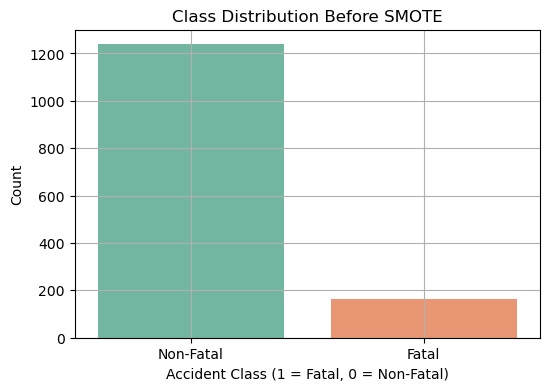


### Visualizing Outliers in Numerical Columns ###


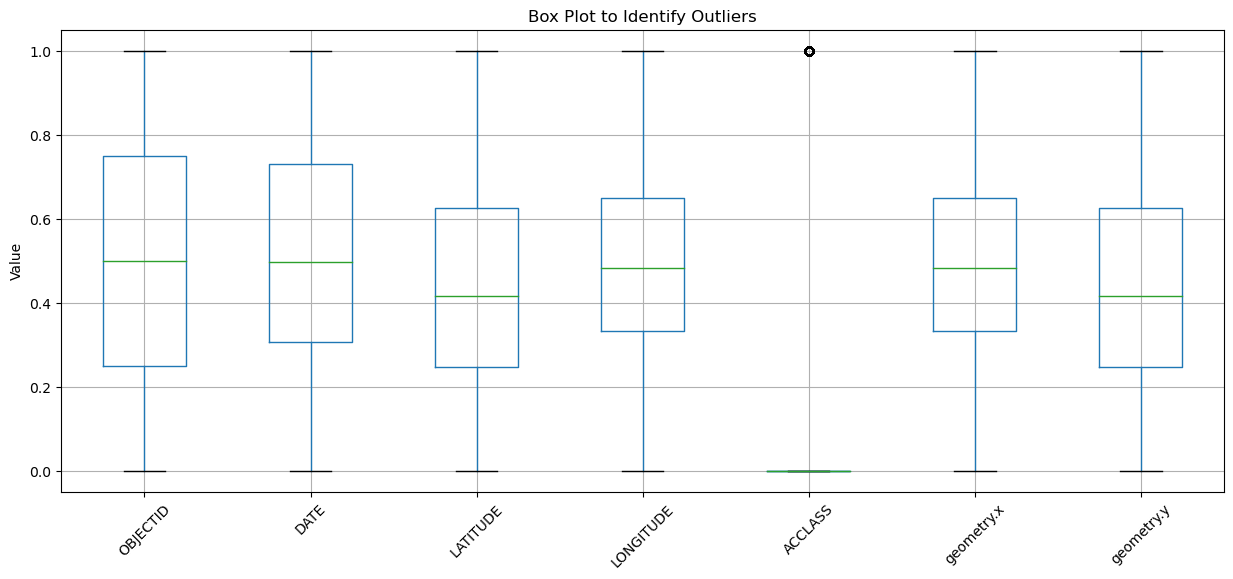


### Dataset Shape Before Handling Outliers ###
(2000, 29)

### Dataset Shape After Handling Outliers ###
(1760, 29)

### Class Distribution After SMOTE ###


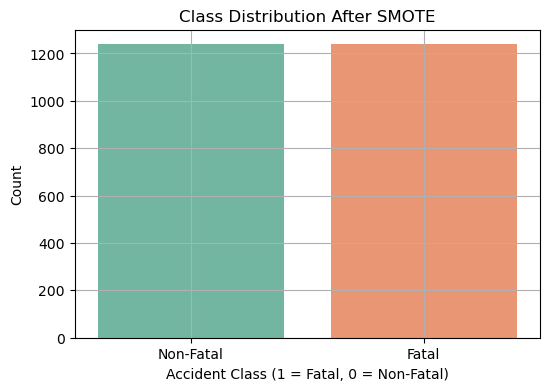


### Accuracy on Test Data: 0.95 ###

### Classification Report ###
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       522
         1.0       0.87      0.76      0.81        78

    accuracy                           0.95       600
   macro avg       0.92      0.87      0.89       600
weighted avg       0.95      0.95      0.95       600



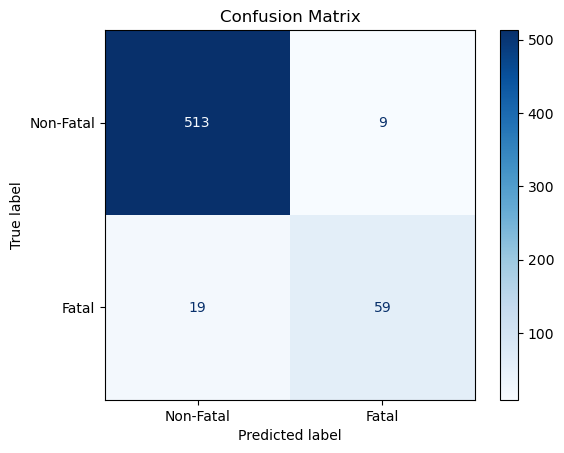


Model saved as 'logistic_regression_model_smote.joblib'
Predictions from the loaded model: [0. 0. 0. 0. 0.]


In [33]:

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 1: Load the Data
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/TOTAL_KSI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
arcgis_edwin = pd.json_normalize(data['features'])
arcgis_edwin.columns = arcgis_edwin.columns.str.replace('attributes.', '')

# Step 2: Initial Exploration
print("\n### Dataset Shape Before Preprocessing ###\n", arcgis_edwin.shape)

# Step 3: Drop Columns with More Than 20% Missing Values
threshold_missing = 0.2  # 20% missing values threshold
missing_percentage = arcgis_edwin.isnull().mean()
columns_to_drop_missing = missing_percentage[missing_percentage > threshold_missing].index
arcgis_edwin.drop(columns=columns_to_drop_missing, inplace=True)

# Step 4: Fill Missing Values (Before Train-Test Split)
for column in arcgis_edwin.columns:
    if arcgis_edwin[column].dtype == 'object':
        mode_value = arcgis_edwin[column].mode()[0] if not arcgis_edwin[column].mode().empty else 'Unknown'
        arcgis_edwin[column].fillna(mode_value, inplace=True)
    else:
        median_value = arcgis_edwin[column].median()
        arcgis_edwin[column].fillna(median_value, inplace=True)

# Step 5: Convert 'ACCLASS' to Binary (Fatal: 1, Non-Fatal: 0)
arcgis_edwin['ACCLASS'] = arcgis_edwin['ACCLASS'].apply(lambda x: 1 if x == 'Fatal' else 0)

# Step 6: Data Normalization (Min-Max Scaling)
def normalize(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = (df[numeric_cols] - df[numeric_cols].min()) / (df[numeric_cols].max() - df[numeric_cols].min())
    return df

arcgis_edwin = normalize(arcgis_edwin)

# Step 7: Split Data into Features and Target
X_edwin = arcgis_edwin.drop('ACCLASS', axis=1)
y_edwin = arcgis_edwin['ACCLASS']

# Train-test split
x_train_edwin, x_test_edwin, y_train_edwin, y_test_edwin = train_test_split(X_edwin, y_edwin, test_size=0.3, random_state=42)

# Convert categorical columns to numeric (if applicable)
x_train_edwin = pd.get_dummies(x_train_edwin, drop_first=True)
x_test_edwin = pd.get_dummies(x_test_edwin, drop_first=True)

# Ensure both train and test sets have the same columns
x_train_edwin, x_test_edwin = x_train_edwin.align(x_test_edwin, join='left', axis=1, fill_value=0)

# Step 8: Visualize the Class Distribution Before SMOTE
def plot_class_distribution(y, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y, palette='Set2')
    plt.title(title)
    plt.xlabel('Accident Class (1 = Fatal, 0 = Non-Fatal)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Non-Fatal', 'Fatal'])
    plt.grid(True)
    plt.show()

print("\n### Class Distribution Before SMOTE ###")
plot_class_distribution(y_train_edwin, "Class Distribution Before SMOTE")

# Step 8.1: Visualize Outliers Using Box Plots
def plot_outliers(df, numeric_cols):
    plt.figure(figsize=(15, 6))
    df[numeric_cols].boxplot()
    plt.xticks(rotation=45)
    plt.title("Box Plot to Identify Outliers")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

# Identify numerical columns
numeric_columns = arcgis_edwin.select_dtypes(include=['number']).columns.tolist()

print("\n### Visualizing Outliers in Numerical Columns ###")
plot_outliers(arcgis_edwin, numeric_columns)

# Step 8.2: Handling Outliers Using the IQR Method
def handle_outliers(df, numeric_cols):
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

print("\n### Dataset Shape Before Handling Outliers ###")
print(arcgis_edwin.shape)

# Remove outliers
arcgis_edwin = handle_outliers(arcgis_edwin, numeric_columns)

print("\n### Dataset Shape After Handling Outliers ###")
print(arcgis_edwin.shape)


# Step 9: Apply SMOTE to Balance the Dataset
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_edwin, y_train_edwin)

# Step 10: Visualize the Class Distribution After SMOTE
print("\n### Class Distribution After SMOTE ###")
plot_class_distribution(y_train_smote, "Class Distribution After SMOTE")

# Step 11: Train a Logistic Regression Model
model_edwin = LogisticRegression(max_iter=1000)
model_edwin.fit(x_train_smote, y_train_smote)

# Step 12: Evaluate Model on Test Data
y_pred_edwin = model_edwin.predict(x_test_edwin)
print(f"\n### Accuracy on Test Data: {accuracy_score(y_test_edwin, y_pred_edwin):.2f} ###")
print(f"\n### Classification Report ###\n{classification_report(y_test_edwin, y_pred_edwin)}")

# Step 13: Confusion Matrix Visualization
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix = ConfusionMatrixDisplay.from_estimator(model_edwin, x_test_edwin, y_test_edwin, display_labels=['Non-Fatal', 'Fatal'], cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


# Step 19: Save the Model
joblib.dump(model_edwin, 'logistic_regression_model_smote.joblib')
print("\nModel saved as 'logistic_regression_model_smote.joblib'")

# Step 20: Load and Predict with the Saved Model
loaded_model = joblib.load('logistic_regression_model_smote.joblib')
y_pred_loaded = loaded_model.predict(x_test_edwin)
print(f"Predictions from the loaded model: {y_pred_loaded[:5]}")



In [34]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load the pre-trained model
try:
    model_edwin = joblib.load('logistic_regression_model_smote.joblib')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Step 1: Fetch the Data
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/TOTAL_KSI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
response = requests.get(url)
data = response.json()

# Step 2: Convert JSON to DataFrame
df = pd.json_normalize(data['features'])
df.columns = [col.split('.')[-1] for col in df.columns]  # Simplify column names

# Step 3: Initial Exploration
print("\n### Initial Data Shape ###")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Step 4: Select Columns to Keep
selected_columns = [
    'ACCNUM', 'TIME', 'ROAD_CLASS', 'DISTRICT', 'LONGITUDE', 'TRAFFCTL', 'VISIBILITY',
    'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY',
    'VEHTYPE', 'AUTOMOBILE', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION'
]
df = df[selected_columns]

# Step 5: Select One Row for Prediction
sample_row = df.sample(n=1)
print("\n### Sample Selected (Before Data Cleaning & Encoding) ###")
print(sample_row)

# Step 6: Handle Missing Values (if any)
sample_row.fillna(sample_row.median(numeric_only=True), inplace=True)

# Step 7: Define Column Transformer
# Identify categorical and numerical columns
numerical_features = sample_row.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = sample_row.select_dtypes(include=['object']).columns.tolist()

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Step 8: Preprocess the Data
sample_row_encoded = preprocessor.fit_transform(sample_row)

# Convert the transformed array back to a DataFrame for alignment
sample_row_encoded_df = pd.DataFrame(
    sample_row_encoded,
    columns=preprocessor.get_feature_names_out()
)

# Step 9: Align with Training Columns
# Get original columns used during training
original_columns = model_edwin.feature_names_in_
aligned_sample_row = sample_row_encoded_df.reindex(columns=original_columns, fill_value=0)

# Ensure it's a 2D array for prediction
aligned_sample_row = aligned_sample_row.values.reshape(1, -1)

# Step 10: Make Predictions
try:
    prediction = model_edwin.predict(aligned_sample_row)
    print("\n### Prediction for Selected Row ###")
    print("Fatal" if prediction[0] == 1 else "Non-Fatal")
except Exception as e:
    print(f"\nError in model prediction: {e}")

print("Feature Names")


Model loaded successfully.

### Initial Data Shape ###
Rows: 2000, Columns: 54

### Sample Selected (Before Data Cleaning & Encoding) ###
      ACCNUM  TIME      ROAD_CLASS     DISTRICT  LONGITUDE    TRAFFCTL  \
1059  925837  2158  Major Arterial  Scarborough  -79.24919  No Control   

     VISIBILITY LIGHT RDSFCOND ACCLASS  ...        INVTYPE   INVAGE INJURY  \
1059       Rain  Dark      Wet   Fatal  ...  Vehicle Owner  unknown   None   

     VEHTYPE AUTOMOBILE HOOD_158 NEIGHBOURHOOD_158 HOOD_140  \
1059   Other        Yes      138     Eglinton East      138   

        NEIGHBOURHOOD_140 DIVISION  
1059  Eglinton East (138)      D43  

[1 rows x 21 columns]

### Prediction for Selected Row ###
Fatal
Feature Names



### Dataset Shape Before Preprocessing ###
 (2000, 54)

### Dataset Shape After Preprocessing ###
(2000, 23)

### Columns Dropped Due to High Missing Values ###
['OFFSET', 'ACCLOC', 'FATAL_NO', 'INITDIR', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY']

### Columns Dropped Due to High Unique Ratios ###
['OBJECTID', 'INDEX_']

### Columns Dropped Due to High Correlation ###
['STREET2', 'STREET1']

### Columns Dropped Due to Low Variance ###
['LATITUDE', 'geometry.y']

### Final List of Columns After Preprocessing ###
['ACCNUM', 'DATE', 'TIME', 'ROAD_CLASS', 'DISTRICT', 'LONGITUDE', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY', 'VEHTYPE', 'AUTOMOBILE', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION', 

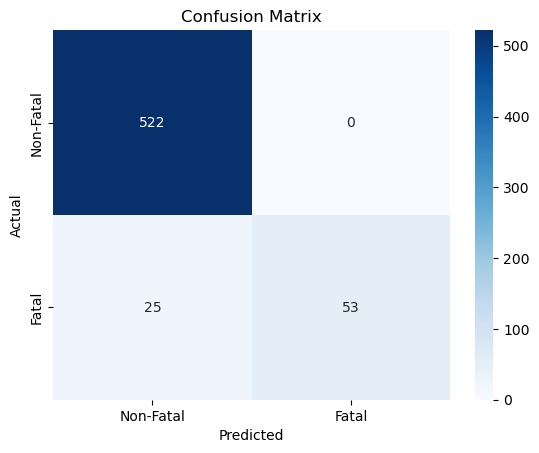


Preprocessor and Model saved successfully.


In [35]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import joblib
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Step 1: Load the Data
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/TOTAL_KSI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
arcgis_edwin = pd.json_normalize(data['features'])
arcgis_edwin.columns = arcgis_edwin.columns.str.replace('attributes.', '')

# Step 2: Initial Exploration
print("\n### Dataset Shape Before Preprocessing ###\n", arcgis_edwin.shape)

# Step 3: Drop Columns with More Than 20% Missing Values
threshold_missing = 0.2  # 20% missing values threshold
missing_percentage = arcgis_edwin.isnull().mean()

# Identify and drop columns with high missing values
columns_to_drop_missing = missing_percentage[missing_percentage > threshold_missing].index
arcgis_edwin.drop(columns=columns_to_drop_missing, inplace=True)

# Step 4: Fill Missing Values (Before Train-Test Split)
for column in arcgis_edwin.columns:
    if arcgis_edwin[column].dtype == 'object':  # Categorical columns
        mode_value = arcgis_edwin[column].mode()[0] if not arcgis_edwin[column].mode().empty else 'Unknown'
        arcgis_edwin[column].fillna(mode_value, inplace=True)
    else:  # Numerical columns
        median_value = arcgis_edwin[column].median()
        arcgis_edwin[column].fillna(median_value, inplace=True)

# Step 5: Set the Threshold for High Unique Ratio (e.g., 50% unique values)
threshold_unique = 0.5  # 50% unique values
unique_ratios = arcgis_edwin.nunique() / arcgis_edwin.shape[0]

# Identify and drop columns with high unique ratios
columns_high_unique = unique_ratios[unique_ratios > threshold_unique].index
arcgis_edwin.drop(columns=columns_high_unique, inplace=True)

# Step 6: Calculate Correlation Matrix and Handle High Correlation
correlation_matrix = arcgis_edwin.corr()

# Identify and drop highly correlated columns (threshold of 0.9)
high_correlation = np.where(abs(correlation_matrix) > 0.9)
high_correlation_pairs = [(arcgis_edwin.columns[x], arcgis_edwin.columns[y]) for x, y in zip(*high_correlation) if x != y and x < y]

columns_to_drop_correlation = []
for (col1, col2) in high_correlation_pairs:
    columns_to_drop_correlation.append(col2)  # Drop the second column in each pair
arcgis_edwin.drop(columns=columns_to_drop_correlation, inplace=True)

# Step 7: Handle Low Variance Features
variances = arcgis_edwin.var()
threshold_variance = 0.01
columns_to_drop_variance = variances[variances < threshold_variance].index

# Drop low variance columns
arcgis_edwin.drop(columns=columns_to_drop_variance, inplace=True)

# Step 8: Dataset Shape After Preprocessing
print("\n### Dataset Shape After Preprocessing ###")
print(arcgis_edwin.shape)

# Step 9: Print the List of Dropped Columns
print("\n### Columns Dropped Due to High Missing Values ###")
print(columns_to_drop_missing.tolist())

print("\n### Columns Dropped Due to High Unique Ratios ###")
print(columns_high_unique.tolist())

print("\n### Columns Dropped Due to High Correlation ###")
print(columns_to_drop_correlation)

print("\n### Columns Dropped Due to Low Variance ###")
print(columns_to_drop_variance.tolist())

# Step 10: Final Columns Array
final_columns = arcgis_edwin.columns.tolist()
print("\n### Final List of Columns After Preprocessing ###")
print(final_columns)

# Step 5: Convert 'ACCLASS' to Binary (Fatal: 1, Non-Fatal: 0)
arcgis_edwin['ACCLASS'] = arcgis_edwin['ACCLASS'].apply(lambda x: 1 if x == 'Fatal' else 0)

# Step 11: Data Transformation (Normalization)
def normalize(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = (df[numeric_cols] - df[numeric_cols].min()) / (df[numeric_cols].max() - df[numeric_cols].min())
    return df

arcgis_edwin = normalize(arcgis_edwin)

# Step 12: Split Data into Features and Target (After Preprocessing)
X_edwin = arcgis_edwin.drop('ACCLASS', axis=1)
y_edwin = arcgis_edwin['ACCLASS']

# Step 13: Identify Numerical and Categorical Columns
numerical_cols = X_edwin.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_edwin.select_dtypes(include=['object']).columns.tolist()

# Step 14: Create Column Transformer with Pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),           # Scale numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols), # Encode categorical columns
    ],
    remainder='passthrough'  # Keep other columns as is
)

# Step 15: Split Data into Train and Test Sets
x_train_edwin, x_test_edwin, y_train_edwin, y_test_edwin = train_test_split(
    X_edwin, y_edwin, test_size=0.3, random_state=42
)

# Step 16: Fit and Transform Train Data, Transform Test Data
x_train_edwin = preprocessor.fit_transform(x_train_edwin)  # Fit and transform for training
x_test_edwin = preprocessor.transform(x_test_edwin)  # Only transform for testing

# Step 17: Ensure NaN Values Are Handled (if any) AFTER transformation
# Convert to DataFrame first for easier handling of NaN values
x_train_edwin = pd.DataFrame(x_train_edwin.toarray())
x_test_edwin = pd.DataFrame(x_test_edwin.toarray())

x_train_edwin = x_train_edwin.apply(pd.to_numeric, errors='coerce')
x_test_edwin = x_test_edwin.apply(pd.to_numeric, errors='coerce')

# Replace infinite values with NaN (if any)
x_train_edwin.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test_edwin.replace([np.inf, -np.inf], np.nan, inplace=True)

x_train_edwin = x_train_edwin.apply(pd.to_numeric, errors='coerce')
x_test_edwin = x_test_edwin.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with column medians
x_train_edwin.fillna(x_train_edwin.median(), inplace=True)
x_test_edwin.fillna(x_test_edwin.median(), inplace=True)

# Step 18: Verify All Columns Are Float (except Target)
print("\n### Data Types After Processing ###")
column_types = pd.DataFrame(x_train_edwin.dtypes, columns=['Data Type'])
print(column_types.sort_index())

# Step 19: Model Building with Logistic Regression
model_edwin = LogisticRegression(max_iter=1000)
#model_edwin = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20)
model_edwin.fit(x_train_edwin, y_train_edwin)

# Step 20: Cross-validation for Model Evaluation
cv_scores = cross_val_score(model_edwin, x_train_edwin, y_train_edwin, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Step 21: Evaluate Model on Test Data
y_pred_edwin = model_edwin.predict(x_test_edwin)
print(f"\n### Accuracy on Test Data: {accuracy_score(y_test_edwin, y_pred_edwin):.2f} ###")
print(f"\n### Classification Report ###\n{classification_report(y_test_edwin, y_pred_edwin)}")

# Step 22: Confusion Matrix
cm = confusion_matrix(y_test_edwin, y_pred_edwin)
print(f"\n### Confusion Matrix ###\n{cm}")

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fatal', 'Fatal'], yticklabels=['Non-Fatal', 'Fatal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 23: Save the Preprocessor and Model
joblib.dump(preprocessor, 'column_transformer.joblib')
joblib.dump(model_edwin, 'logistic_regression_model_smote.joblib')
print("\nPreprocessor and Model saved successfully.")



### Dataset Shape Before Preprocessing ###
 (2000, 54)

### Class Distribution Before SMOTE ###


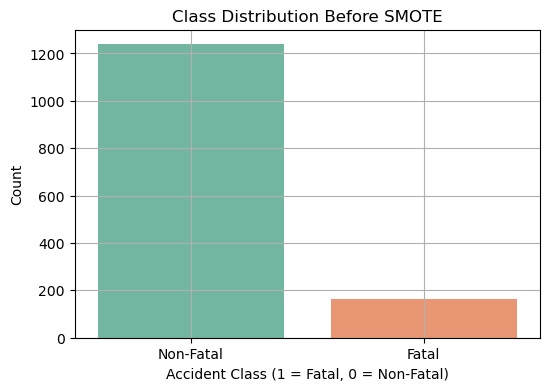


### Visualizing Outliers in Numerical Columns ###


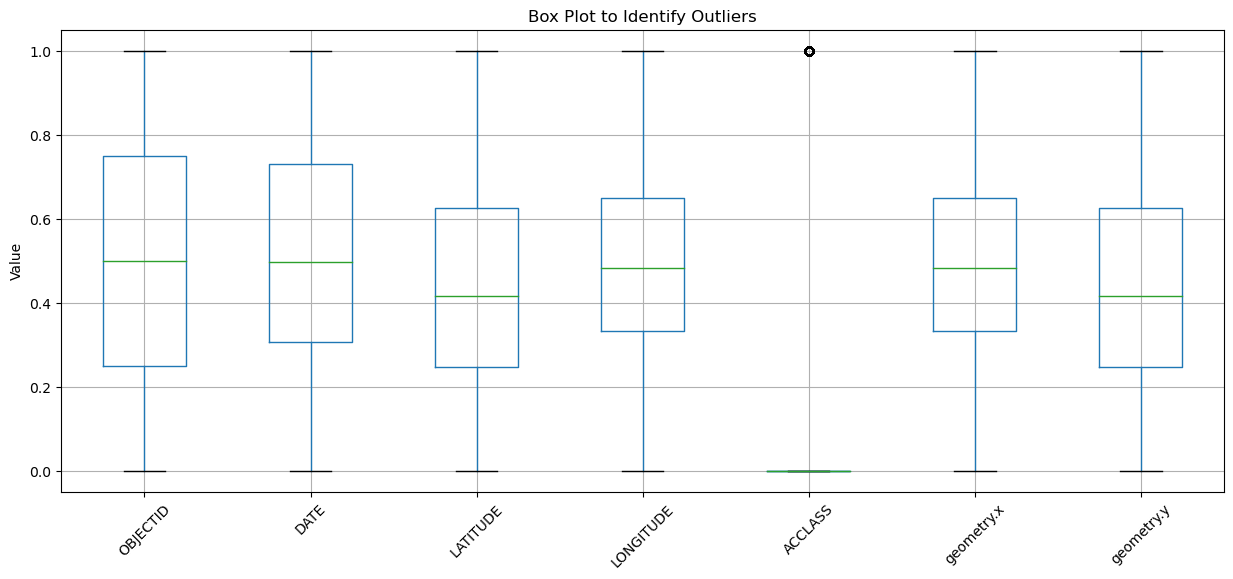


### Dataset Shape Before Handling Outliers ###
(2000, 29)

### Dataset Shape After Handling Outliers ###
(1760, 29)

### Class Distribution After SMOTE ###


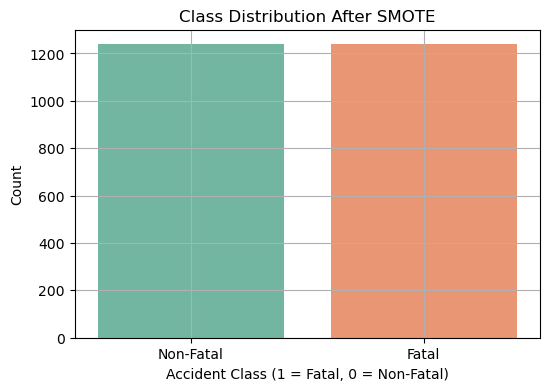


### Accuracy on Test Data: 0.95 ###

### Classification Report ###
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       522
         1.0       0.87      0.76      0.81        78

    accuracy                           0.95       600
   macro avg       0.92      0.87      0.89       600
weighted avg       0.95      0.95      0.95       600



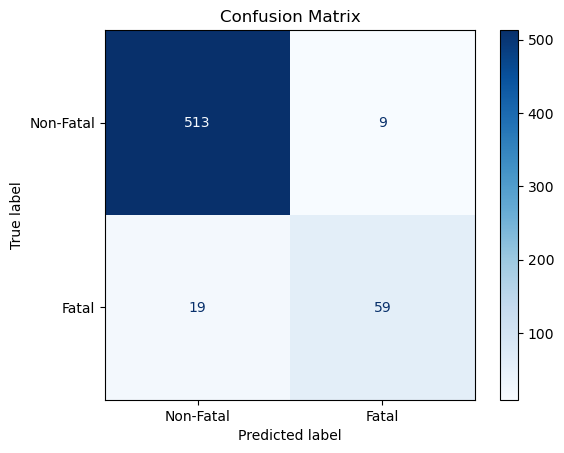


Model saved as 'logistic_regression_model_smote.joblib'
Predictions from the loaded model: [0. 0. 0. 0. 0.]


In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 1: Load the Data
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/TOTAL_KSI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
arcgis_edwin = pd.json_normalize(data['features'])
arcgis_edwin.columns = arcgis_edwin.columns.str.replace('attributes.', '')

# Step 2: Initial Exploration
print("\n### Dataset Shape Before Preprocessing ###\n", arcgis_edwin.shape)

# Step 3: Drop Columns with More Than 20% Missing Values
threshold_missing = 0.2  # 20% missing values threshold
missing_percentage = arcgis_edwin.isnull().mean()
columns_to_drop_missing = missing_percentage[missing_percentage > threshold_missing].index
arcgis_edwin.drop(columns=columns_to_drop_missing, inplace=True)

# Step 4: Fill Missing Values (Before Train-Test Split)
for column in arcgis_edwin.columns:
    if arcgis_edwin[column].dtype == 'object':
        mode_value = arcgis_edwin[column].mode()[0] if not arcgis_edwin[column].mode().empty else 'Unknown'
        arcgis_edwin[column].fillna(mode_value, inplace=True)
    else:
        median_value = arcgis_edwin[column].median()
        arcgis_edwin[column].fillna(median_value, inplace=True)

# Step 5: Convert 'ACCLASS' to Binary (Fatal: 1, Non-Fatal: 0)
arcgis_edwin['ACCLASS'] = arcgis_edwin['ACCLASS'].apply(lambda x: 1 if x == 'Fatal' else 0)

# Step 6: Data Normalization (Min-Max Scaling)
def normalize(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = (df[numeric_cols] - df[numeric_cols].min()) / (df[numeric_cols].max() - df[numeric_cols].min())
    return df

arcgis_edwin = normalize(arcgis_edwin)

# Step 7: Split Data into Features and Target
X_edwin = arcgis_edwin.drop('ACCLASS', axis=1)
y_edwin = arcgis_edwin['ACCLASS']

# Train-test split
x_train_edwin, x_test_edwin, y_train_edwin, y_test_edwin = train_test_split(X_edwin, y_edwin, test_size=0.3, random_state=42)

# Convert categorical columns to numeric (if applicable)
x_train_edwin = pd.get_dummies(x_train_edwin, drop_first=True)
x_test_edwin = pd.get_dummies(x_test_edwin, drop_first=True)

# Ensure both train and test sets have the same columns
x_train_edwin, x_test_edwin = x_train_edwin.align(x_test_edwin, join='left', axis=1, fill_value=0)

# Step 8: Visualize the Class Distribution Before SMOTE
def plot_class_distribution(y, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y, palette='Set2')
    plt.title(title)
    plt.xlabel('Accident Class (1 = Fatal, 0 = Non-Fatal)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Non-Fatal', 'Fatal'])
    plt.grid(True)
    plt.show()

print("\n### Class Distribution Before SMOTE ###")
plot_class_distribution(y_train_edwin, "Class Distribution Before SMOTE")

# Step 8.1: Visualize Outliers Using Box Plots
def plot_outliers(df, numeric_cols):
    plt.figure(figsize=(15, 6))
    df[numeric_cols].boxplot()
    plt.xticks(rotation=45)
    plt.title("Box Plot to Identify Outliers")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

# Identify numerical columns
numeric_columns = arcgis_edwin.select_dtypes(include=['number']).columns.tolist()

print("\n### Visualizing Outliers in Numerical Columns ###")
plot_outliers(arcgis_edwin, numeric_columns)

# Step 8.2: Handling Outliers Using the IQR Method
def handle_outliers(df, numeric_cols):
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

print("\n### Dataset Shape Before Handling Outliers ###")
print(arcgis_edwin.shape)

# Remove outliers
arcgis_edwin = handle_outliers(arcgis_edwin, numeric_columns)

print("\n### Dataset Shape After Handling Outliers ###")
print(arcgis_edwin.shape)


# Step 9: Apply SMOTE to Balance the Dataset
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_edwin, y_train_edwin)

# Step 10: Visualize the Class Distribution After SMOTE
print("\n### Class Distribution After SMOTE ###")
plot_class_distribution(y_train_smote, "Class Distribution After SMOTE")

# Step 11: Train a Logistic Regression Model
model_edwin = LogisticRegression(max_iter=1000)
model_edwin.fit(x_train_smote, y_train_smote)

# Step 12: Evaluate Model on Test Data
y_pred_edwin = model_edwin.predict(x_test_edwin)
print(f"\n### Accuracy on Test Data: {accuracy_score(y_test_edwin, y_pred_edwin):.2f} ###")
print(f"\n### Classification Report ###\n{classification_report(y_test_edwin, y_pred_edwin)}")

# Step 13: Confusion Matrix Visualization
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix = ConfusionMatrixDisplay.from_estimator(model_edwin, x_test_edwin, y_test_edwin, display_labels=['Non-Fatal', 'Fatal'], cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


# Step 19: Save the Model
joblib.dump(model_edwin, 'logistic_regression_model_smote.joblib')
print("\nModel saved as 'logistic_regression_model_smote.joblib'")

# Step 20: Load and Predict with the Saved Model
loaded_model = joblib.load('logistic_regression_model_smote.joblib')
y_pred_loaded = loaded_model.predict(x_test_edwin)
print(f"Predictions from the loaded model: {y_pred_loaded[:5]}")


In [37]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load the pre-trained model
try:
    model_edwin = joblib.load('logistic_regression_model_smote.joblib')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Step 1: Fetch the Data
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/TOTAL_KSI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
response = requests.get(url)
data = response.json()

# Step 2: Convert JSON to DataFrame
df = pd.json_normalize(data['features'])
df.columns = [col.split('.')[-1] for col in df.columns]  # Simplify column names

# Step 3: Initial Exploration
print("\n### Initial Data Shape ###")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Step 4: Select Columns to Keep
selected_columns = [
    'ACCNUM', 'TIME', 'ROAD_CLASS', 'DISTRICT', 'LONGITUDE', 'TRAFFCTL', 'VISIBILITY',
    'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY',
    'VEHTYPE', 'AUTOMOBILE', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION'
]
df = df[selected_columns]

# Step 5: Select One Row for Prediction
sample_row = df.sample(n=1)
print("\n### Sample Selected (Before Data Cleaning & Encoding) ###")
print(sample_row)

# Step 6: Handle Missing Values (if any)
sample_row.fillna(sample_row.median(numeric_only=True), inplace=True)

# Step 7: Define Column Transformer
# Identify categorical and numerical columns
numerical_features = sample_row.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = sample_row.select_dtypes(include=['object']).columns.tolist()

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Step 8: Preprocess the Data
sample_row_encoded = preprocessor.fit_transform(sample_row)

# Convert the transformed array back to a DataFrame for alignment
sample_row_encoded_df = pd.DataFrame(
    sample_row_encoded,
    columns=preprocessor.get_feature_names_out()
)

# Step 9: Align with Training Columns
# Get original columns used during training
original_columns = model_edwin.feature_names_in_
aligned_sample_row = sample_row_encoded_df.reindex(columns=original_columns, fill_value=0)

# Ensure it's a 2D array for prediction
aligned_sample_row = aligned_sample_row.values.reshape(1, -1)

# Step 10: Make Predictions
try:
    prediction = model_edwin.predict(aligned_sample_row)
    print("\n### Prediction for Selected Row ###")
    print("Fatal" if prediction[0] == 1 else "Non-Fatal")
except Exception as e:
    print(f"\nError in model prediction: {e}")

print("Feature Names")

Model loaded successfully.

### Initial Data Shape ###
Rows: 2000, Columns: 54

### Sample Selected (Before Data Cleaning & Encoding) ###
     ACCNUM  TIME      ROAD_CLASS        DISTRICT  LONGITUDE        TRAFFCTL  \
517  907251  2141  Major Arterial  Etobicoke York  -79.57489  Traffic Signal   

    VISIBILITY LIGHT RDSFCOND           ACCLASS  ... INVTYPE    INVAGE  \
517      Clear  Dark      Dry  Non-Fatal Injury  ...  Driver  45 to 49   

      INJURY                    VEHTYPE AUTOMOBILE HOOD_158 NEIGHBOURHOOD_158  \
517  Minimal  Automobile, Station Wagon        Yes      NSA               NSA   

    HOOD_140 NEIGHBOURHOOD_140 DIVISION  
517      NSA               NSA      NSA  

[1 rows x 21 columns]

### Prediction for Selected Row ###
Fatal
Feature Names



### Dataset Shape Before Preprocessing ###
 (2000, 54)

### Dataset Shape After Preprocessing ###
(2000, 23)

### Columns Dropped Due to High Missing Values ###
['OFFSET', 'ACCLOC', 'FATAL_NO', 'INITDIR', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY']

### Columns Dropped Due to High Unique Ratios ###
['OBJECTID', 'INDEX_']

### Columns Dropped Due to High Correlation ###
['STREET2', 'STREET1']

### Columns Dropped Due to Low Variance ###
['LATITUDE', 'geometry.y']

### Final List of Columns After Preprocessing ###
['ACCNUM', 'DATE', 'TIME', 'ROAD_CLASS', 'DISTRICT', 'LONGITUDE', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY', 'VEHTYPE', 'AUTOMOBILE', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION', 

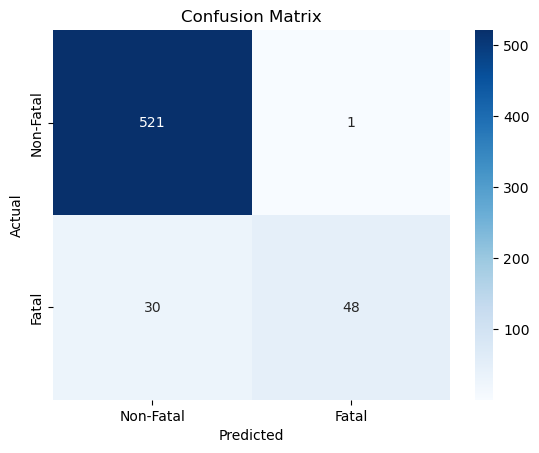


Model saved as 'logistic_regression_model_smote.joblib'
Predictions from the loaded model: [0. 0. 0. 0. 0.]


In [38]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import joblib
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Load the Data
url ="https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/TOTAL_KSI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
arcgis_edwin = pd.json_normalize(data['features'])
arcgis_edwin.columns = arcgis_edwin.columns.str.replace('attributes.', '')

# Step 2: Initial Exploration
print("\n### Dataset Shape Before Preprocessing ###\n", arcgis_edwin.shape)

# Step 3: Drop Columns with More Than 20% Missing Values
threshold_missing = 0.2  # 20% missing values threshold
missing_percentage = arcgis_edwin.isnull().mean()

# Identify and drop columns with high missing values
columns_to_drop_missing = missing_percentage[missing_percentage > threshold_missing].index
arcgis_edwin.drop(columns=columns_to_drop_missing, inplace=True)

# Step 4: Fill Missing Values (Before Train-Test Split)
for column in arcgis_edwin.columns:
    if arcgis_edwin[column].dtype == 'object':  # Categorical columns
        mode_value = arcgis_edwin[column].mode()[0] if not arcgis_edwin[column].mode().empty else 'Unknown'
        arcgis_edwin[column].fillna(mode_value, inplace=True)
    else:  # Numerical columns
        median_value = arcgis_edwin[column].median()
        arcgis_edwin[column].fillna(median_value, inplace=True)

# Step 5: Set the Threshold for High Unique Ratio (e.g., 50% unique values)
threshold_unique = 0.5  # 50% unique values
unique_ratios = arcgis_edwin.nunique() / arcgis_edwin.shape[0]

# Identify and drop columns with high unique ratios
columns_high_unique = unique_ratios[unique_ratios > threshold_unique].index
arcgis_edwin.drop(columns=columns_high_unique, inplace=True)

# Step 6: Calculate Correlation Matrix and Handle High Correlation
correlation_matrix = arcgis_edwin.corr()

# Identify and drop highly correlated columns (threshold of 0.9)
high_correlation = np.where(abs(correlation_matrix) > 0.9)
high_correlation_pairs = [(arcgis_edwin.columns[x], arcgis_edwin.columns[y]) for x, y in zip(*high_correlation) if x != y and x < y]

columns_to_drop_correlation = []
for (col1, col2) in high_correlation_pairs:
    columns_to_drop_correlation.append(col2)  # Drop the second column in each pair
arcgis_edwin.drop(columns=columns_to_drop_correlation, inplace=True)

# Step 7: Handle Low Variance Features
variances = arcgis_edwin.var()
threshold_variance = 0.01
columns_to_drop_variance = variances[variances < threshold_variance].index

# Drop low variance columns
arcgis_edwin.drop(columns=columns_to_drop_variance, inplace=True)

# Step 8: Dataset Shape After Preprocessing
print("\n### Dataset Shape After Preprocessing ###")
print(arcgis_edwin.shape)

# Step 9: Print the List of Dropped Columns
print("\n### Columns Dropped Due to High Missing Values ###")
print(columns_to_drop_missing.tolist())

print("\n### Columns Dropped Due to High Unique Ratios ###")
print(columns_high_unique.tolist())

print("\n### Columns Dropped Due to High Correlation ###")
print(columns_to_drop_correlation)

print("\n### Columns Dropped Due to Low Variance ###")
print(columns_to_drop_variance.tolist())

# Step 10: Final Columns Array
final_columns = arcgis_edwin.columns.tolist()
print("\n### Final List of Columns After Preprocessing ###")
print(final_columns)

# Step 5: Convert 'ACCLASS' to Binary (Fatal: 1, Non-Fatal: 0)
arcgis_edwin['ACCLASS'] = arcgis_edwin['ACCLASS'].apply(lambda x: 1 if x == 'Fatal' else 0)

# Step 11: Data Transformation (Normalization)
def normalize(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = (df[numeric_cols] - df[numeric_cols].min()) / (df[numeric_cols].max() - df[numeric_cols].min())
    return df

arcgis_edwin = normalize(arcgis_edwin)

# Step 12: Split Data into Features and Target (After Preprocessing)
X_edwin = arcgis_edwin.drop('ACCLASS', axis=1)
y_edwin = arcgis_edwin['ACCLASS']

# Train-test split
x_train_edwin, x_test_edwin, y_train_edwin, y_test_edwin = train_test_split(X_edwin, y_edwin, test_size=0.3, random_state=42)

# Convert categorical columns to numeric (if applicable)
x_train_edwin = pd.get_dummies(x_train_edwin, drop_first=True)
x_test_edwin = pd.get_dummies(x_test_edwin, drop_first=True)

# Ensure both train and test sets have the same columns
x_train_edwin, x_test_edwin = x_train_edwin.align(x_test_edwin, join='left', axis=1, fill_value=0)

# Step 13: Handle NaN, Infinity, and Large Values (Before Scaling)
x_train_edwin.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test_edwin.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN with column median
x_train_edwin.fillna(x_train_edwin.median(), inplace=True)
x_test_edwin.fillna(x_test_edwin.median(), inplace=True)

# Step 14: Verify All Columns Are Float (except Target)
print("\n### Data Types After Processing ###")
column_types = pd.DataFrame(x_train_edwin.dtypes, columns=['Data Type'])
print(column_types.sort_index())

# Ensure all columns are of type float64 except for the target
non_float_columns = column_types[column_types['Data Type'] != 'float64']
if not non_float_columns.empty:
    print("\n### Columns That Are Not of Type Float64 ###")
    print(non_float_columns)
else:
    print("\nAll feature columns are of type float64.")

# Step 15: Model Building
model_edwin = LogisticRegression(max_iter=1000)
model_edwin.fit(x_train_edwin, y_train_edwin)

# Step 16: Cross-validation for Model Evaluation
cv_scores = cross_val_score(model_edwin, x_train_edwin, y_train_edwin, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Step 17: Evaluate Model on Test Data
y_pred_edwin = model_edwin.predict(x_test_edwin)
print(f"\n### Accuracy on Test Data: {accuracy_score(y_test_edwin, y_pred_edwin):.2f} ###")
print(f"\n### Classification Report ###\n{classification_report(y_test_edwin, y_pred_edwin)}")

# Step 18: Confusion Matrix
cm = confusion_matrix(y_test_edwin, y_pred_edwin)
print(f"\n### Confusion Matrix ###\n{cm}")

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fatal', 'Fatal'], yticklabels=['Non-Fatal', 'Fatal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 19: Save the Model
joblib.dump(model_edwin, 'logistic_regression_model_smote.joblib')
print("\nModel saved as 'logistic_regression_model_smote.joblib'")

# Step 20: Load and Predict with the Saved Model
loaded_model = joblib.load('logistic_regression_model_smote.joblib')
y_pred_loaded = loaded_model.predict(x_test_edwin)
print(f"Predictions from the loaded model: {y_pred_loaded[:5]}")


In [39]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load the pre-trained model
try:
    model_edwin = joblib.load('logistic_regression_model_smote.joblib')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Step 1: Fetch the Data
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/TOTAL_KSI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
response = requests.get(url)
data = response.json()

# Step 2: Convert JSON to DataFrame
df = pd.json_normalize(data['features'])
df.columns = [col.split('.')[-1] for col in df.columns]  # Simplify column names

# Step 3: Initial Exploration
print("\n### Initial Data Shape ###")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Step 4: Select Columns to Keep
selected_columns = [
    'ACCNUM', 'TIME', 'ROAD_CLASS', 'DISTRICT', 'LONGITUDE', 'TRAFFCTL', 'VISIBILITY',
    'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY',
    'VEHTYPE', 'AUTOMOBILE', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION'
]
df = df[selected_columns]

# Step 5: Select One Row for Prediction
sample_row = df.sample(n=1)
print("\n### Sample Selected (Before Data Cleaning & Encoding) ###")
print(sample_row)

# Step 6: Handle Missing Values (if any)
sample_row.fillna(sample_row.median(numeric_only=True), inplace=True)

# Step 7: Define Column Transformer
# Identify categorical and numerical columns
numerical_features = sample_row.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = sample_row.select_dtypes(include=['object']).columns.tolist()

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Step 8: Preprocess the Data
sample_row_encoded = preprocessor.fit_transform(sample_row)

# Convert the transformed array back to a DataFrame for alignment
sample_row_encoded_df = pd.DataFrame(
    sample_row_encoded,
    columns=preprocessor.get_feature_names_out()
)

# Step 9: Align with Training Columns
# Get original columns used during training
original_columns = model_edwin.feature_names_in_
aligned_sample_row = sample_row_encoded_df.reindex(columns=original_columns, fill_value=0)

# Ensure it's a 2D array for prediction
aligned_sample_row = aligned_sample_row.values.reshape(1, -1)

# Step 10: Make Predictions
try:
    prediction = model_edwin.predict(aligned_sample_row)
    print("\n### Prediction for Selected Row ###")
    print("Fatal" if prediction[0] == 1 else "Non-Fatal")
except Exception as e:
    print(f"\nError in model prediction: {e}")

print("Feature Names")


Model loaded successfully.

### Initial Data Shape ###
Rows: 2000, Columns: 54

### Sample Selected (Before Data Cleaning & Encoding) ###
     ACCNUM  TIME      ROAD_CLASS        DISTRICT  LONGITUDE        TRAFFCTL  \
351  903114  2044  Major Arterial  Etobicoke York  -79.55619  Traffic Signal   

    VISIBILITY LIGHT RDSFCOND           ACCLASS  ... INVTYPE    INVAGE INJURY  \
351      Clear  Dark      Dry  Non-Fatal Injury  ...  Driver  25 to 29   None   

                       VEHTYPE AUTOMOBILE HOOD_158      NEIGHBOURHOOD_158  \
351  Automobile, Station Wagon        Yes      159  Etobicoke City Centre   

    HOOD_140                NEIGHBOURHOOD_140 DIVISION  
351       14  Islington-City Centre West (14)      D22  

[1 rows x 21 columns]

### Prediction for Selected Row ###
Non-Fatal
Feature Names


In [40]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Load the pre-trained model
try:
    model_edwin = joblib.load('logistic_regression_model_smote.joblib')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Step 1: Fetch the Data
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/TOTAL_KSI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
response = requests.get(url)
data = response.json()

# Step 2: Convert JSON to DataFrame
df = pd.json_normalize(data['features'])
df.columns = [col.split('.')[-1] for col in df.columns]  # Simplify column names

# Step 3: Initial Exploration
print("\n### Initial Data Shape ###")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Step 4: Select Columns to Keep
selected_columns = [
    'ACCNUM', 'TIME', 'ROAD_CLASS', 'DISTRICT', 'LONGITUDE', 'TRAFFCTL', 'VISIBILITY',
    'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY',
    'VEHTYPE', 'AUTOMOBILE', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION'
]
df = df[selected_columns]

# Step 5: Select One Row for Prediction
sample_row = df.sample(n=1)
print("\n### Sample Selected (Before Data Cleaning & Encoding) ###")
print(sample_row)

# Step 6: Handle Missing Values (if any)
sample_row.fillna(sample_row.median(numeric_only=True), inplace=True)

# Step 7: Define Column Transformer
# Identify categorical and numerical columns
numerical_features = sample_row.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = sample_row.select_dtypes(include=['object']).columns.tolist()

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Step 8: Preprocess the Data
sample_row_encoded = preprocessor.fit_transform(sample_row)

# Convert the transformed array back to a DataFrame for alignment
sample_row_encoded_df = pd.DataFrame(
    sample_row_encoded,
    columns=preprocessor.get_feature_names_out()
)

# Step 9: Align with Training Columns
# Get original columns used during training
original_columns = model_edwin.feature_names_in_
aligned_sample_row = sample_row_encoded_df.reindex(columns=original_columns, fill_value=0)

# Ensure it's a 2D array for prediction
aligned_sample_row = aligned_sample_row.values.reshape(1, -1)

# Step 10: Make Predictions
try:
    prediction = model_edwin.predict(aligned_sample_row)
    print("\n### Prediction for Selected Row ###")
    print("Fatal" if prediction[0] == 1 else "Non-Fatal")
except Exception as e:
    print(f"\nError in model prediction: {e}")

print("Feature Names")


Model loaded successfully.

### Initial Data Shape ###
Rows: 2000, Columns: 54

### Sample Selected (Before Data Cleaning & Encoding) ###
     ACCNUM  TIME      ROAD_CLASS     DISTRICT  LONGITUDE        TRAFFCTL  \
237  898163  1743  Major Arterial  Scarborough  -79.32439  Traffic Signal   

    VISIBILITY     LIGHT RDSFCOND           ACCLASS  ... INVTYPE    INVAGE  \
237      Clear  Daylight      Dry  Non-Fatal Injury  ...  Driver  25 to 29   

    INJURY                    VEHTYPE AUTOMOBILE HOOD_158 NEIGHBOURHOOD_158  \
237  Major  Automobile, Station Wagon        Yes      NSA               NSA   

    HOOD_140 NEIGHBOURHOOD_140 DIVISION  
237      NSA               NSA      D42  

[1 rows x 21 columns]

### Prediction for Selected Row ###
Non-Fatal
Feature Names


In [41]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

# Function to load the pre-trained model
def load_model(model_path='logistic_regression_model_smote2.joblib'):
    try:
        model = joblib.load(model_path)
        print("Model loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        exit()

# Function to fetch data from the API
def fetch_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        print("Data fetched successfully.")
        return data
    else:
        print(f"Error fetching data: {response.status_code}")
        exit()

# Function to convert JSON data into a DataFrame
def convert_json_to_dataframe(data):
    df = pd.json_normalize(data['features'])
    df.columns = [col.split('.')[-1] for col in df.columns]  # Simplify column names
    return df

# Function to select relevant columns from the DataFrame
def select_columns(df):
    selected_columns = [
        'ACCNUM', 'TIME', 'ROAD_CLASS', 'DISTRICT', 'LONGITUDE', 'TRAFFCTL', 'VISIBILITY',
        'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY',
        'VEHTYPE', 'AUTOMOBILE', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION'
    ]
    df = df[selected_columns]
    return df

# Function to handle missing values in the sample row
def handle_missing_values(sample_row):
    sample_row.fillna(sample_row.median(numeric_only=True), inplace=True)
    return sample_row

# Function to define the column transformer (scaler for numerical, one-hot encoder for categorical)
def create_column_transformer(sample_row):
    numerical_features = sample_row.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = sample_row.select_dtypes(include=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )
    return preprocessor

# Function to preprocess the sample row
def preprocess_sample_row(preprocessor, sample_row):
    sample_row_encoded = preprocessor.fit_transform(sample_row)
    sample_row_encoded_df = pd.DataFrame(
        sample_row_encoded,
        columns=preprocessor.get_feature_names_out()
    )
    return sample_row_encoded_df

# Function to align the sample row with the model's feature names
def align_with_model_columns(sample_row_encoded_df, model_edwin):
    original_columns = model_edwin.feature_names_in_
    aligned_sample_row = sample_row_encoded_df.reindex(columns=original_columns, fill_value=0)
    aligned_sample_row = aligned_sample_row.values.reshape(1, -1)
    return aligned_sample_row

# Function to make a prediction using the model
def make_prediction(model_edwin, aligned_sample_row):
    try:
        prediction = model_edwin.predict(aligned_sample_row)
        print(f"Prediction: {prediction}")
        return "Fatal" if prediction[0] == 1 else "Non-Fatal"
    except Exception as e:
        print(f"Error in model prediction: {e}")
        return None
    
# Function to verify if the loaded model is Logistic Regression
# Function to verify if the loaded model is Logistic Regression
def verify_logistic_regression(model):
    if isinstance(model, LogisticRegression):
        print("The model is a Logistic Regression model.")
    else:
        print(f"The model is not a Logistic Regression model. It is a {model.__class__.__name__}.")





    # Other steps...


# Main function to handle the process
def main():
    # Load the pre-trained model
    model_edwin = joblib.load('logistic_regression_model_smote2.joblib')
    print("Model loaded successfully.")
        
    # Verify if the model is Logistic Regression
    verify_logistic_regression(model_edwin)

    # Fetch the data from the API
    url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/TOTAL_KSI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
    data = fetch_data(url)

    # Convert JSON to DataFrame
    df = convert_json_to_dataframe(data)

    # Initial exploration
    print("\n### Initial Data Shape ###")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    # Select columns to keep
    df = select_columns(df)

    # Select a sample row for prediction
    sample_row = df.sample(n=1)
    print("\n### Sample Selected (Before Data Cleaning & Encoding) ###")
    print(sample_row)

    # Handle missing values
    sample_row = handle_missing_values(sample_row)

    # Create a column transformer for preprocessing
    preprocessor = create_column_transformer(sample_row)

    # Preprocess the sample row
    sample_row_encoded_df = preprocess_sample_row(preprocessor, sample_row)

    # Align the sample row with the model's expected input
    aligned_sample_row = align_with_model_columns(sample_row_encoded_df, model_edwin)

    # Make the prediction
    prediction = make_prediction(model_edwin, aligned_sample_row)
    if prediction:
        print("\n### Prediction for Selected Row ###")
        print(prediction)

if __name__ == "__main__":
    main()


Model loaded successfully.
The model is a Logistic Regression model.
Data fetched successfully.

### Initial Data Shape ###
Rows: 2000, Columns: 54

### Sample Selected (Before Data Cleaning & Encoding) ###
      ACCNUM TIME      ROAD_CLASS     DISTRICT  LONGITUDE        TRAFFCTL  \
1990  970644  440  Major Arterial  Scarborough  -79.29729  Traffic Signal   

     VISIBILITY LIGHT RDSFCOND ACCLASS  ... INVTYPE    INVAGE INJURY  \
1990      Clear  Dark      Dry   Fatal  ...  Driver  20 to 24   None   

                        VEHTYPE AUTOMOBILE HOOD_158 NEIGHBOURHOOD_158  \
1990  Automobile, Station Wagon        Yes      130          Milliken   

     HOOD_140 NEIGHBOURHOOD_140 DIVISION  
1990      130    Milliken (130)      D42  

[1 rows x 21 columns]
Prediction: [1.]

### Prediction for Selected Row ###
Fatal


<!-- We need the following endpoints:
- 8080/api/tasks (create tasks)
- 8080/api/tasks/:email (get all tasks for user)
- 8080/api/:id (update/delete a task) -->